In [1]:
%matplotlib inline

/Users/George/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Import packages

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt

/Users/George/anaconda/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.3.1 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Read data

In [3]:
df = pd.read_csv('zzz.xls', delimiter='\t', names=['cov', 'det', 't'])

Rename columns

In [4]:
print df.shape
df.columns = ['cov', 'det', 't']
df.drop('t', axis=1, inplace=True)
df.head()

(152, 3)


,cov,det
0,2,ND
1,2,ND
2,6,ND
3,7,ND
4,8,ND


Map the ND column:
- 'ND' maps to 'ND'
- all other values map to 'AA'

In [5]:
df['det'] = df['det'].map(lambda x: 'ND' if x == 'ND' else 'AA')

Group by coverage measurement, subsequently compute the total

In [6]:
df_gp = df.groupby(['cov', 'det'], group_keys=False)
df_counts = df_gp.size().unstack().fillna(0)
df_counts['total'] = df_counts['AA'] + df_counts['ND']

Reset the indices; I couldn't figure out how to rename the index column (currently **det**) without adding an extra level_0 index.

In [7]:
df_counts = df_counts.reset_index()
df_counts.reset_index()
df_counts.set_index('cov', inplace=True)
df_counts.index.name = None

In [8]:
df_counts.head()

det,AA,ND,total
2,0.0,2.0,2.0
6,0.0,1.0,1.0
7,0.0,1.0,1.0
8,0.0,2.0,2.0
13,0.0,5.0,5.0


Fill in missing coverage values (i.e. **det** column)

In [9]:
existing_rows = list(df_counts.index.values)
new_rows_idx = [i for i in xrange(max(df_counts.index)) if i not in existing_rows]
df_counts = df_counts.append(
    pd.DataFrame({'AA': 0, 'ND': 0, 'total': 0}, index=new_rows_idx)
)
df_counts = df_counts.sort_index()

### Calculate moving averages for better density visualization

Take the moving average with a centered window (see argument `window=50`).

In [10]:
df_ma = df_counts.rolling(window=50, center=True).mean()

Now calculate percentages

In [11]:
df_ma['pct_AA'] = df_ma.AA / df_ma.total
# df_ma.pct_AA.fillna(1., inplace=True)
df_ma['pct_ND'] = 1 - df_ma.pct_AA

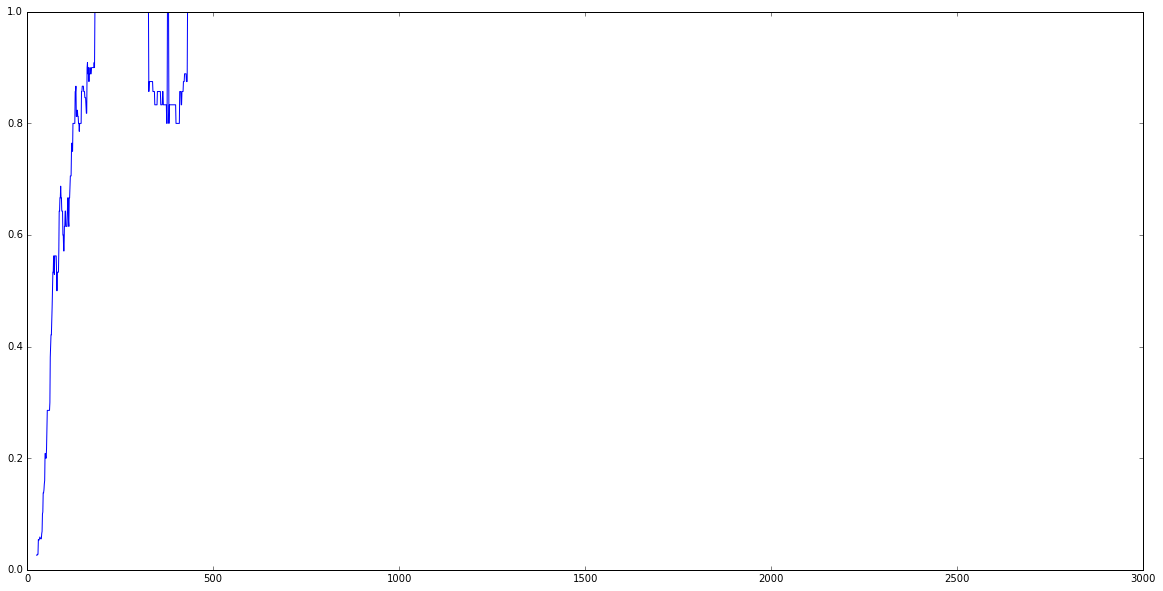

In [12]:
plt.figure(figsize=(20,10))
plt.plot(df_ma.pct_AA)

### Logistic Regression

Create logistic regression instance from `sklearn`.

In [13]:
clf = LogisticRegression() # fit_intercept=False)

Create 0-1 indicators for classifier

In [14]:
df['det_ind'] = df['det'].map(lambda x: 0 if x =='ND' else 1)

Reshape data

In [15]:
y1 = df.det_ind.values.reshape(-1,1)
X1 = df['cov'].values.reshape(-1,1)

Fit logistic regression instance

In [16]:
clf.fit(X1, y1)

/Users/George/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predictions for the current dataset

In [17]:
clf.predict(X1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [18]:
print clf.coef_, clf.intercept_

[[ 0.01940778]] [-1.84854323]


Create an array for plotting dummy curve for logistic regression best fit line

In [19]:
X_test = np.linspace(0, max(X1)[0])

Quick function for plugging back into logistic regression function

In [20]:
def lgr_model(x):
    return 1 / (1 + np.exp(-x))

In [21]:
y_test = lgr_model(X_test * clf.coef_ + clf.intercept_).ravel()

Plot the best fit curve, moving average (red), and observed data (blue)

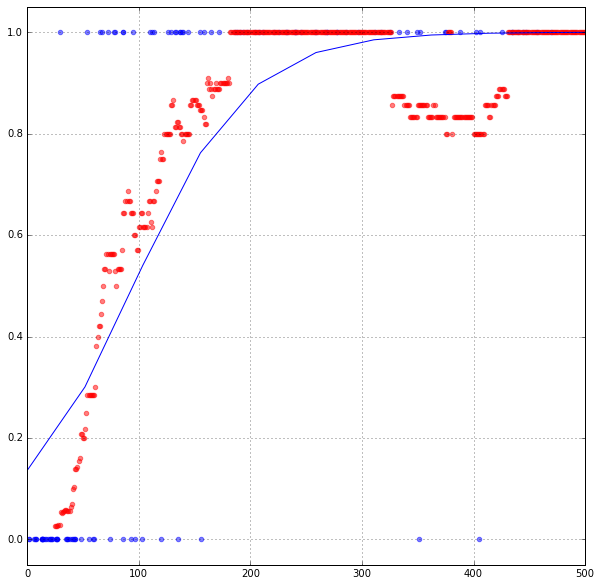

In [22]:
plt.figure(figsize=(10,10))
plt.plot(X_test, y_test)
plt.scatter(X1,y1, color='blue', alpha=0.5)
plt.scatter(df_ma.index, df_ma.pct_AA, color='red', alpha=0.5)
plt.xlim(0,500)
plt.ylim(-0.05, 1.05)
plt.grid()